In [1]:
import torch; 
print(torch.version.cuda)

10.2


In [2]:
# Helper function for visualization.
%matplotlib inline
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
import torch
import networkx as nx
import community.community_louvain
from torch_geometric.data import InMemoryDataset, Data

class KarateClub(InMemoryDataset):
    r"""Zachary's karate club network from the `"An Information Flow Model for
    Conflict and Fission in Small Groups"
    <http://www1.ind.ku.dk/complexLearning/zachary1977.pdf>`_ paper, containing
    34 nodes, connected by 154 (undirected and unweighted) edges.
    Every node is labeled by one of four classes obtained via modularity-based
    clustering, following the `"Semi-supervised Classification with Graph
    Convolutional Networks" <https://arxiv.org/abs/1609.02907>`_ paper.
    Training is based on a single labeled example per class, *i.e.* a total
    number of 4 labeled nodes.

    Args:
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
    """
    def __init__(self, transform=None):
        super(KarateClub, self).__init__('.', transform, None, None)

        G = nx.karate_club_graph()

        x = torch.eye(G.number_of_nodes(), dtype=torch.float)

        adj = nx.to_scipy_sparse_matrix(G).tocoo()
        row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
        col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
        edge_index = torch.stack([row, col], dim=0)

        # Compute communities.
        partition = community.community_louvain.best_partition(G)
        y = torch.tensor([partition[i] for i in range(G.number_of_nodes())])

        # Select a single training node for each community
        # (we just use the first one).
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        for i in range(int(y.max()) + 1):
            train_mask[(y == i).nonzero(as_tuple=False)[0]] = True

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)

        self.data, self.slices = self.collate([data])

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [4]:
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [5]:
dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [6]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [7]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

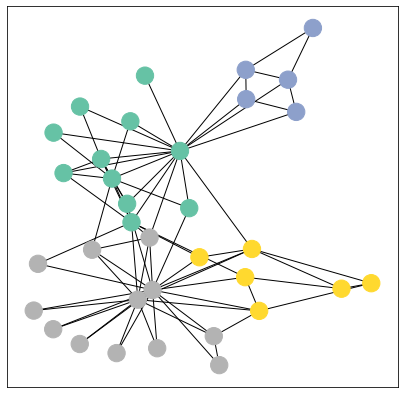

In [8]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

In [9]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [10]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

In [11]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embeddings even before training

Embedding shape: [34, 2]


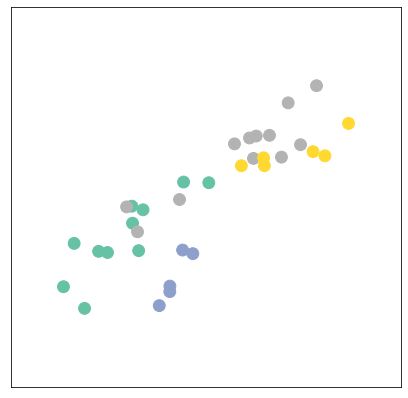

In [12]:
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

In [13]:
def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

<IPython.core.display.Javascript object>

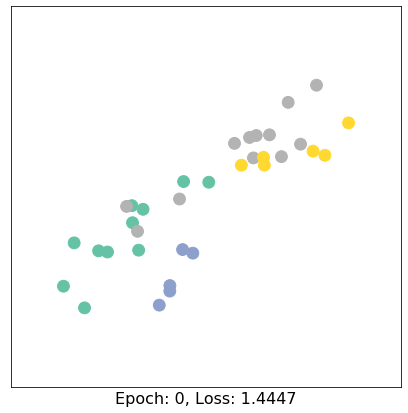

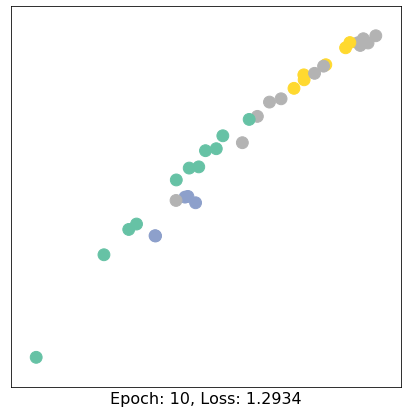

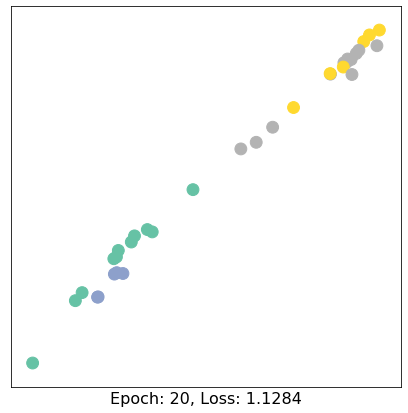

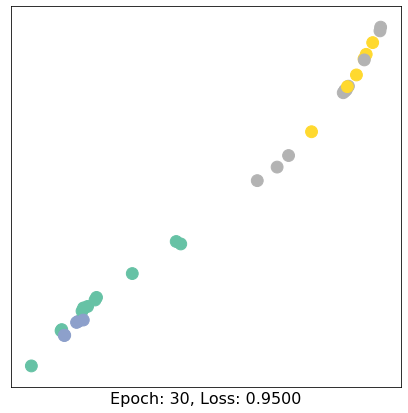

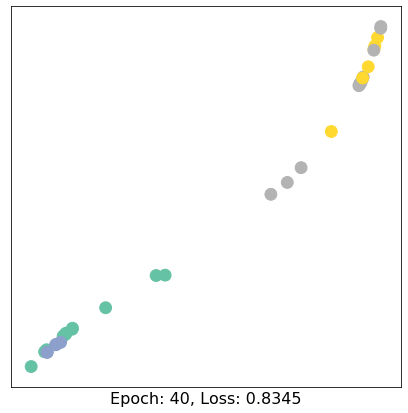

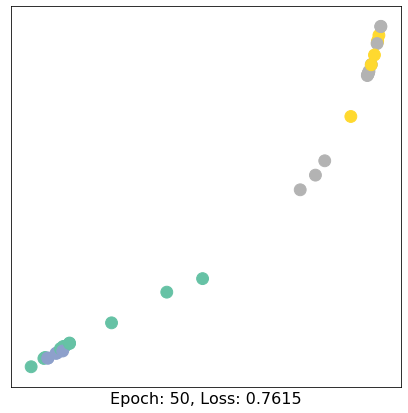

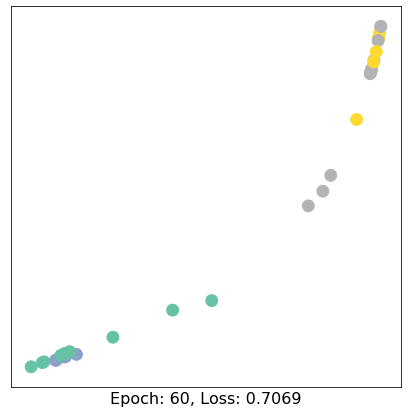

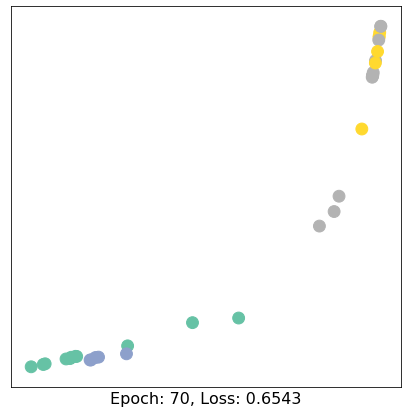

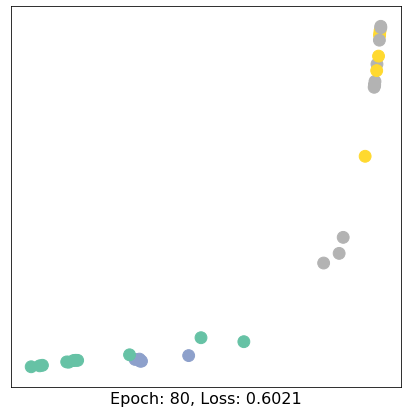

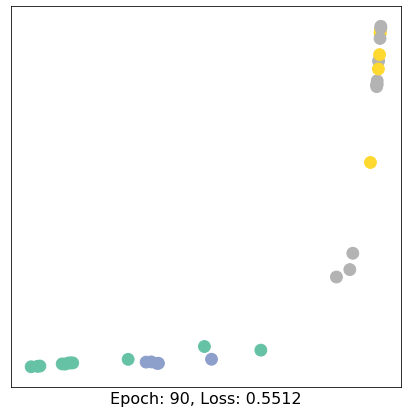

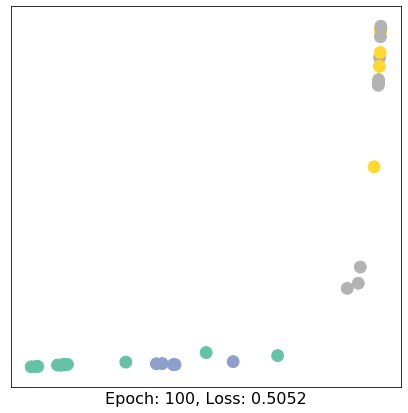

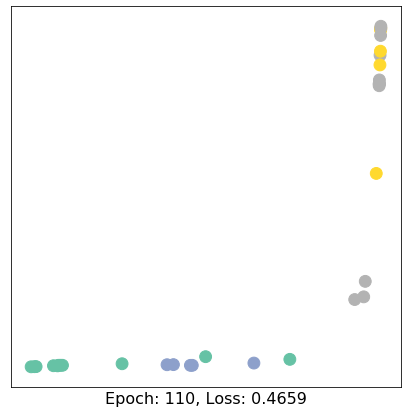

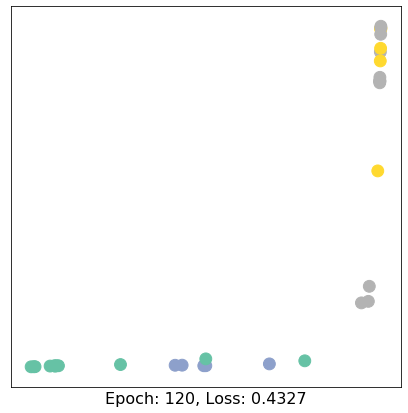

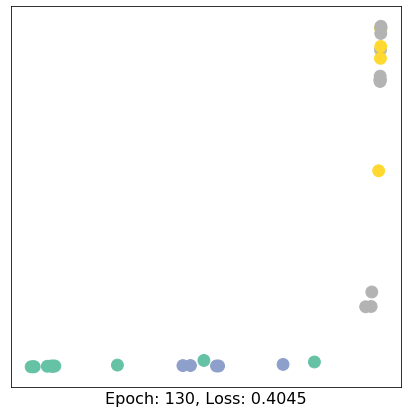

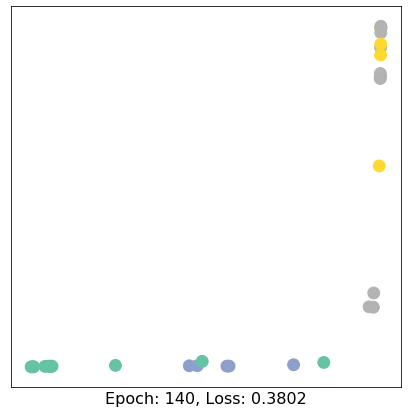

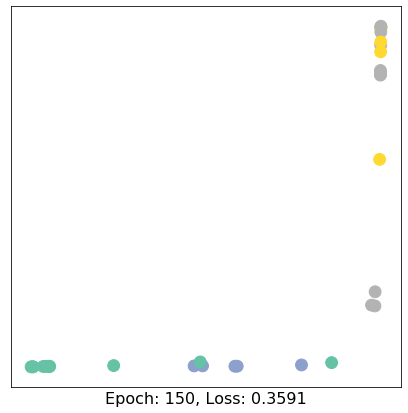

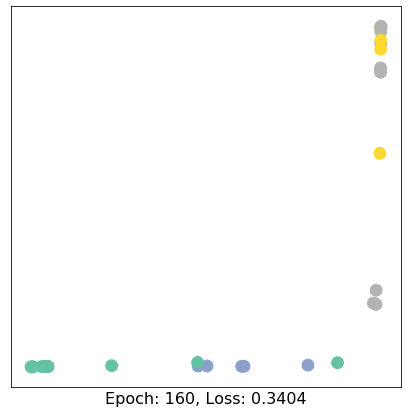

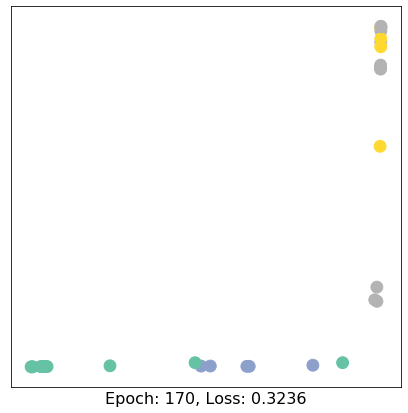

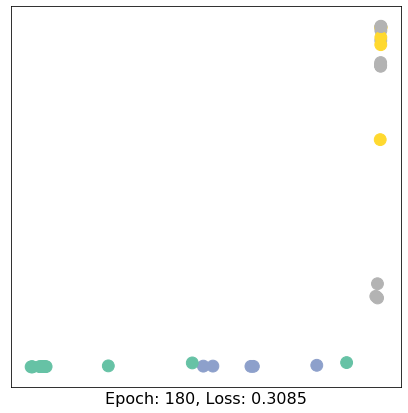

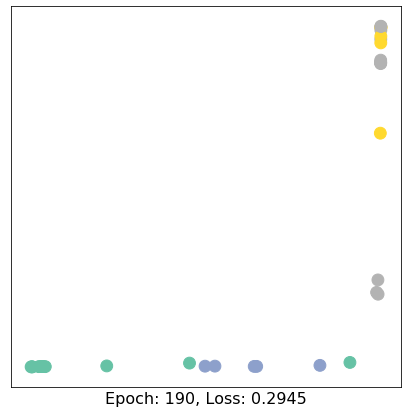

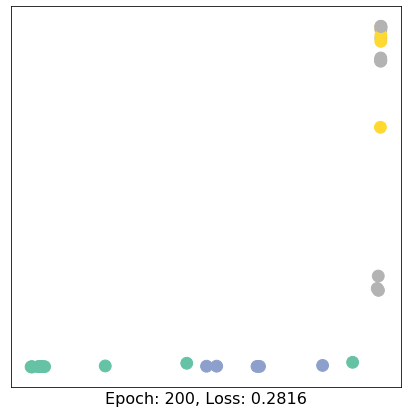

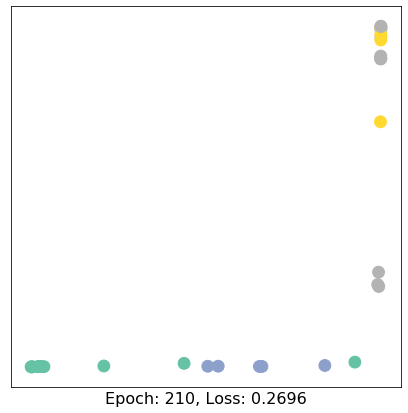

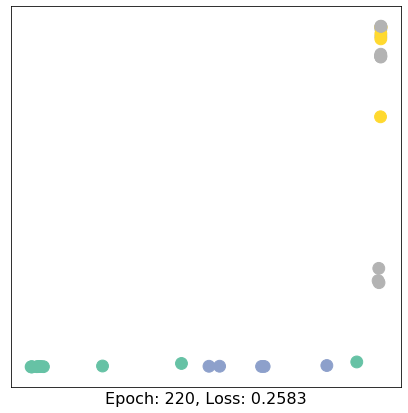

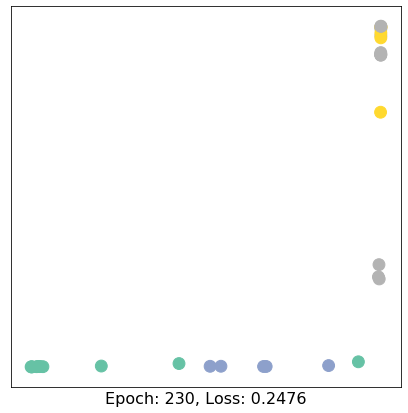

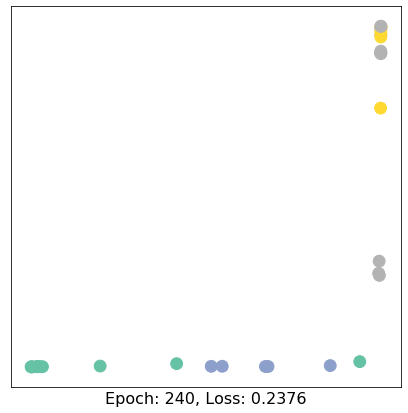

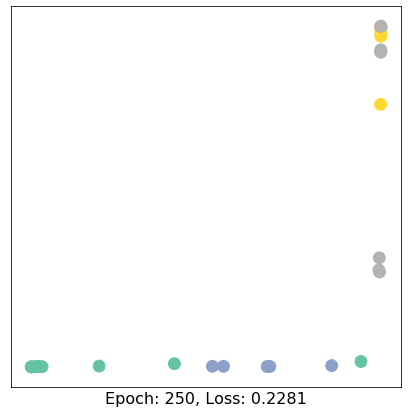

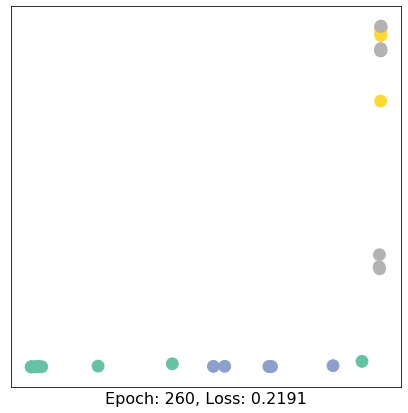

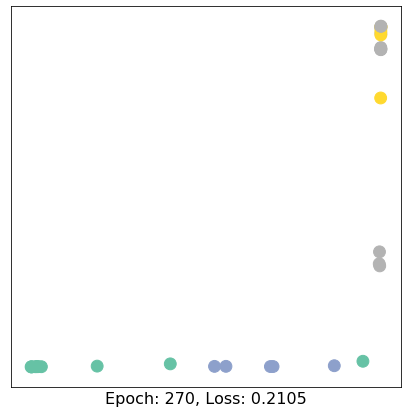

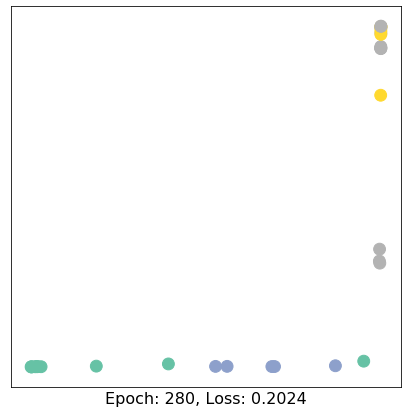

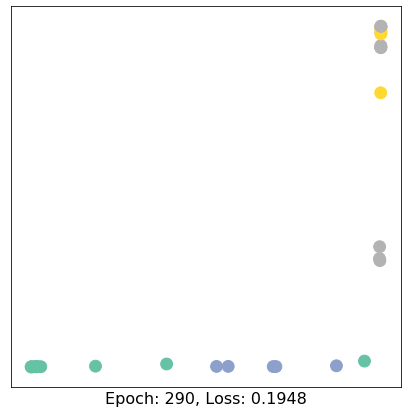

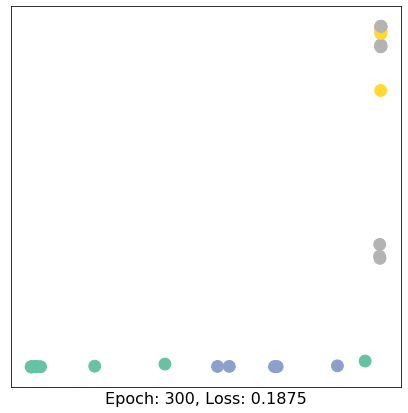

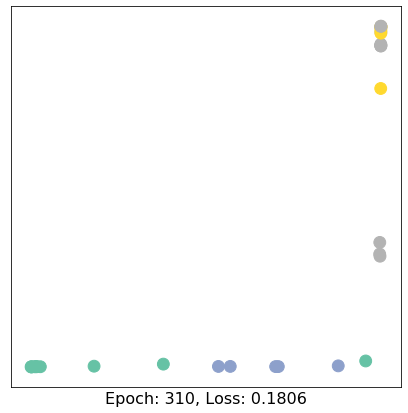

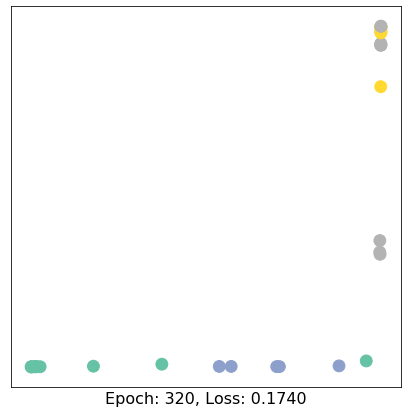

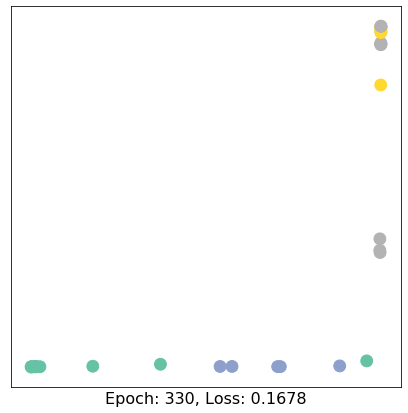

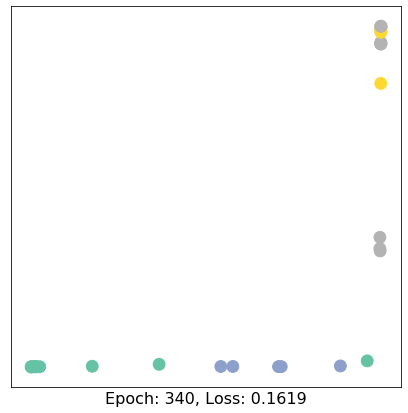

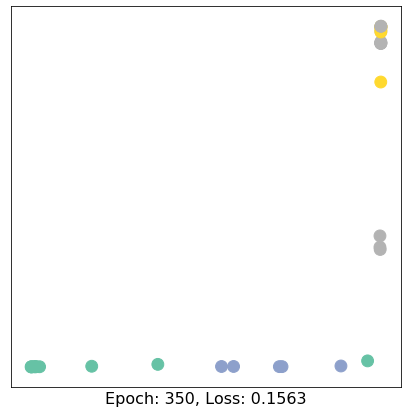

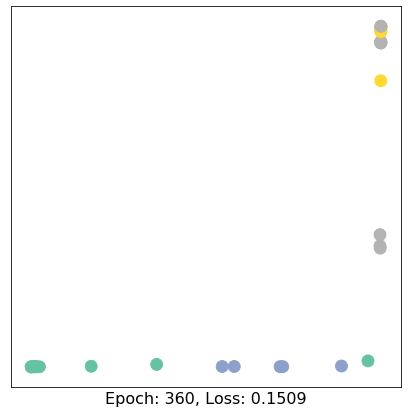

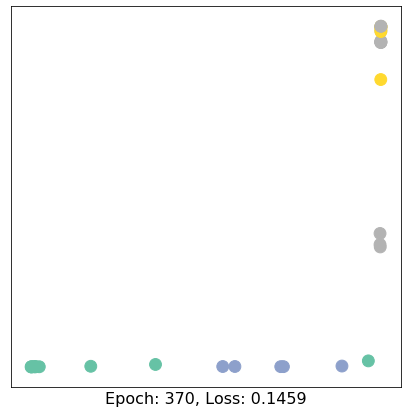

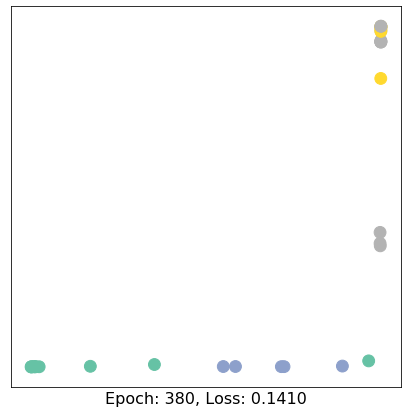

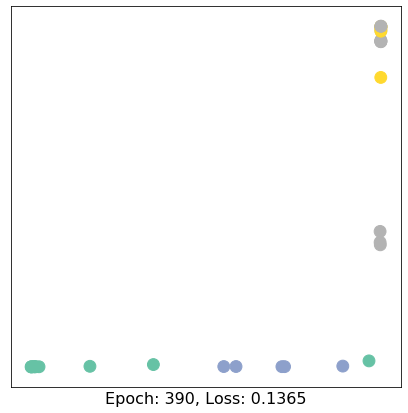

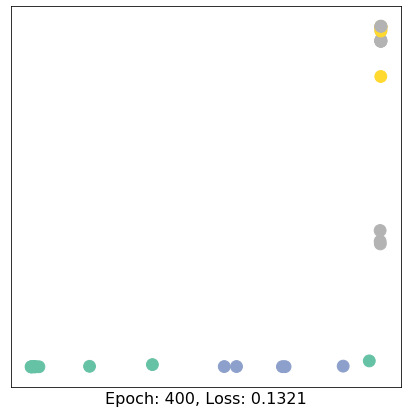

In [14]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

In [36]:
data.y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [2]:
G = nx.karate_club_graph()

In [7]:
partition = community.community_louvain.best_partition(G)
y = torch.tensor([partition[i] for i in range(G.number_of_nodes())])

In [8]:
y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 2,
        2, 2, 0, 2, 2, 0, 0, 2, 0, 0])

In [9]:
y.size(0)

34

In [11]:
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
for i in range(int(y.max()) + 1):
    train_mask[(y == i).nonzero(as_tuple=False)[0]] = True

In [12]:
train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False])